<a href="https://colab.research.google.com/github/VitalyGladyshev/DB_rep/blob/master/HW3_GladyshevVV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 3 Гладышев ВВ

## Задание 1

Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.

```sql
select job_industry_category, count(customer_id) as cust_cnt
from customers c
group by c.job_industry_category
order by cust_cnt desc;
```

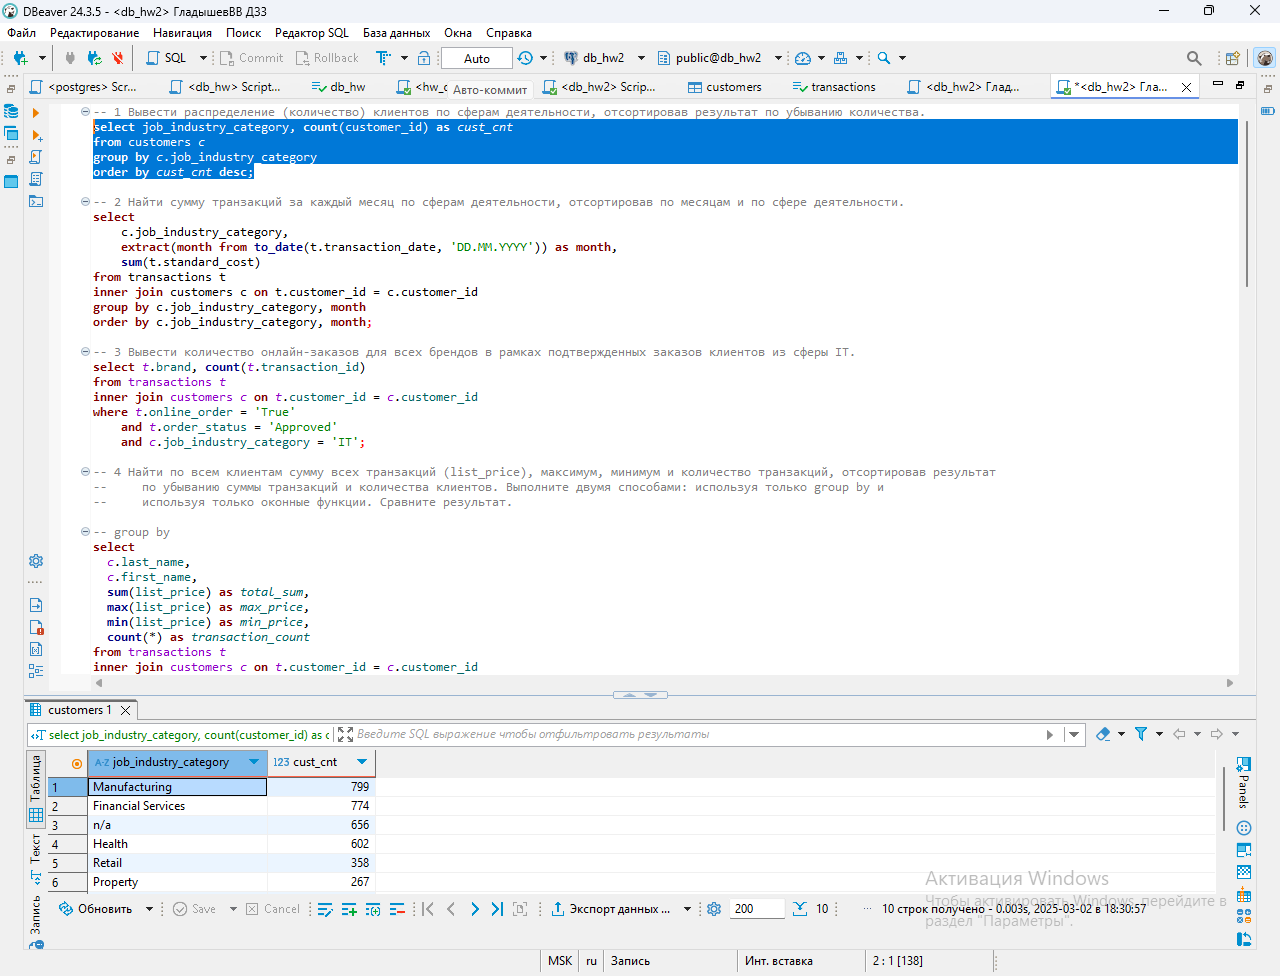

## Задание 2

Найти сумму транзакций за каждый месяц по сферам деятельности, отсортировав по месяцам и по сфере деятельности.

```sql
select
	c.job_industry_category,
	extract(month from to_date(t.transaction_date, 'DD.MM.YYYY')) as month,
	sum(t.standard_cost)
from transactions t
inner join customers c on t.customer_id = c.customer_id
group by c.job_industry_category, month
order by c.job_industry_category, month;
```

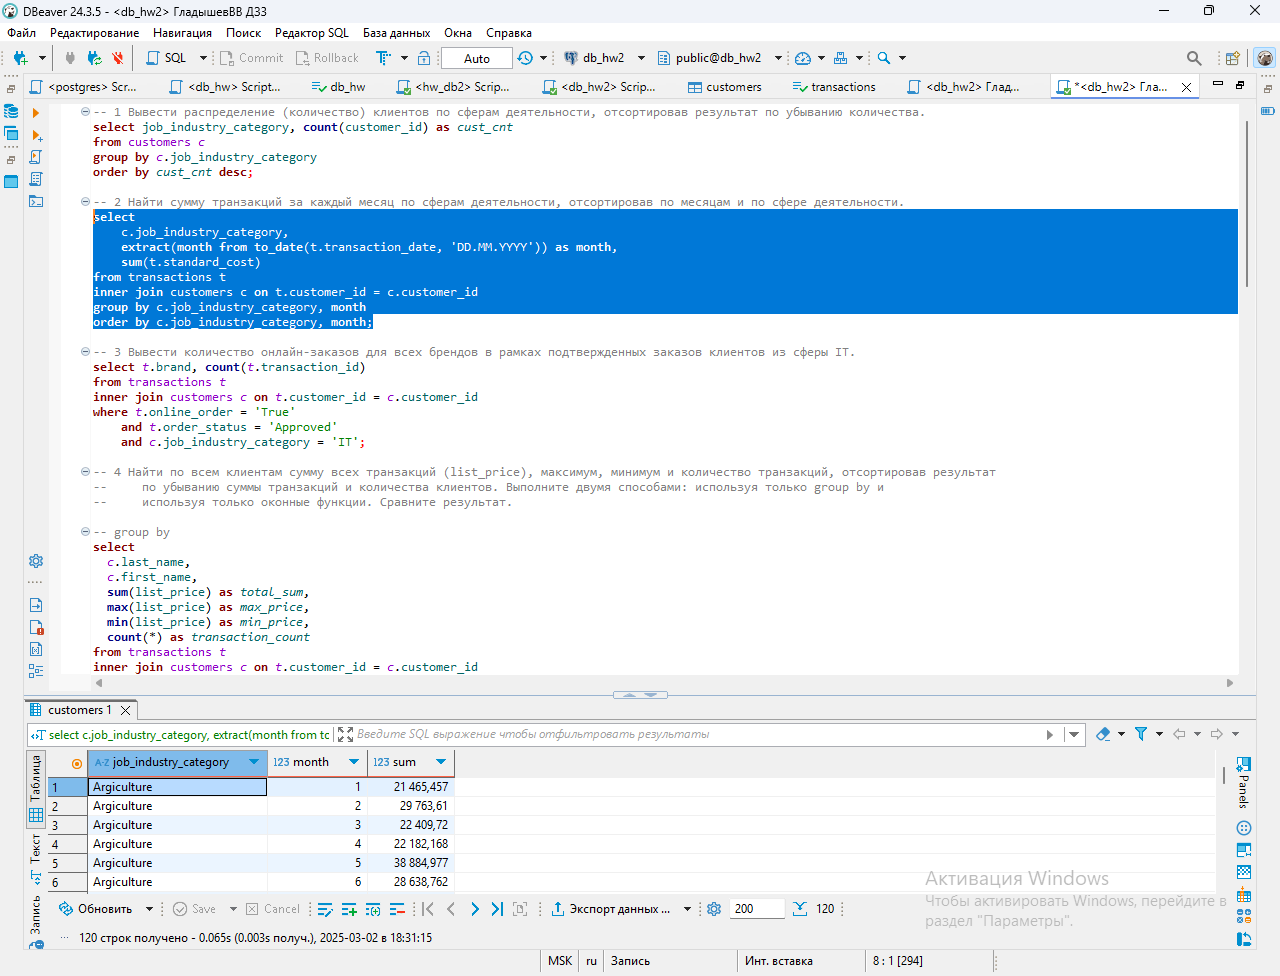

## Задание 3

Вывести количество онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT.

```sql
select t.brand, count(t.transaction_id)
from transactions t
inner join customers c on t.customer_id = c.customer_id
where t.online_order = 'True'
	and t.order_status = 'Approved'
	and c.job_industry_category = 'IT'
group by t.brand;
```

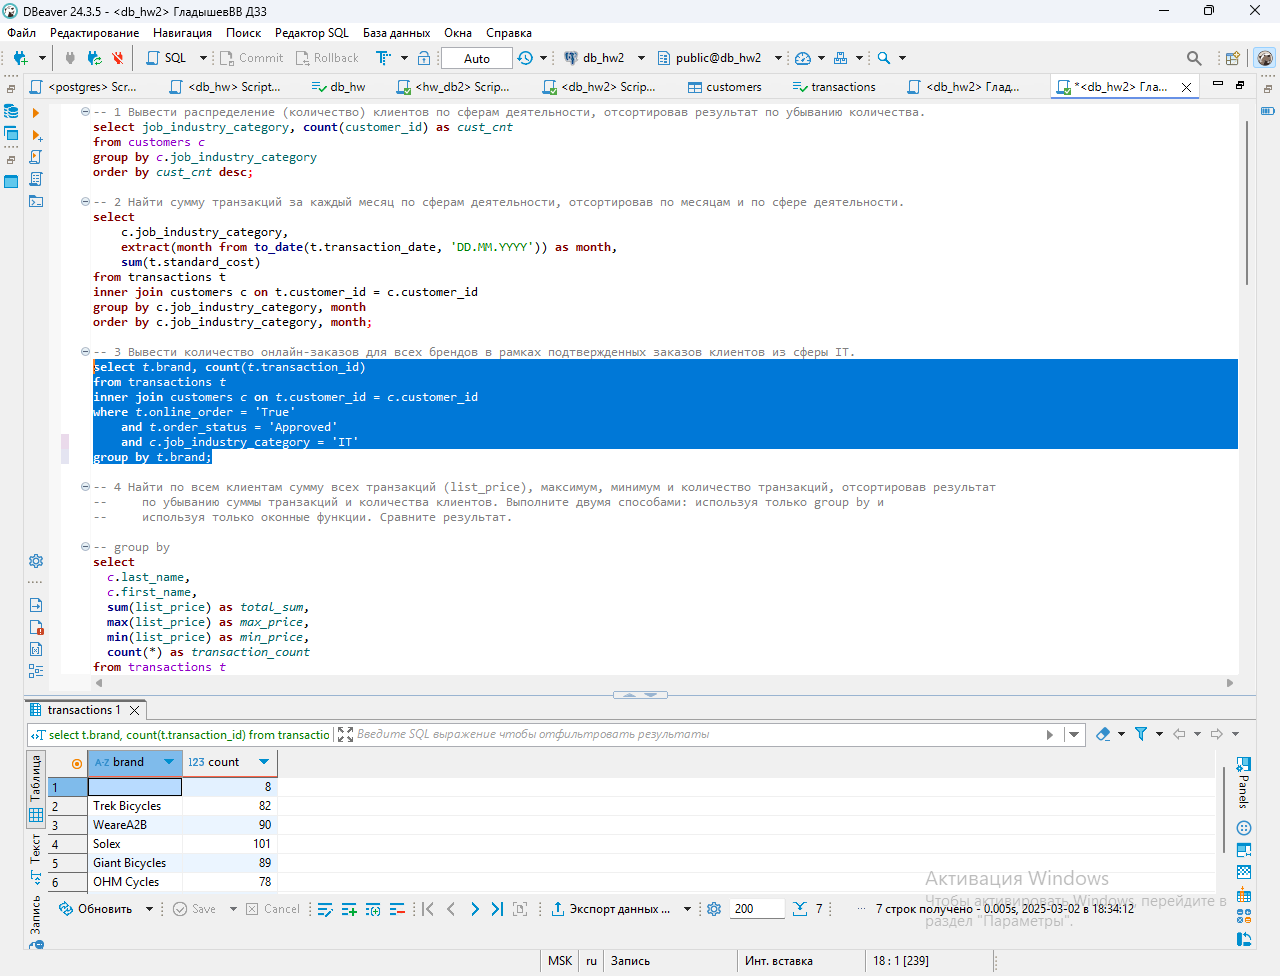

## Задание 4

Найти по всем клиентам сумму всех транзакций (list_price), максимум, минимум и количество транзакций, отсортировав результат по убыванию суммы транзакций и количества клиентов. Выполните двумя способами: используя только group by и используя только оконные функции. Сравните результат.

### group by

```sql
select
  c.last_name,
  c.first_name,
  sum(list_price) as total_sum,
  max(list_price) as max_price,
  min(list_price) as min_price,
  count(*) as transaction_count
from transactions t
inner join customers c on t.customer_id = c.customer_id
group by c.customer_id
order by transaction_count desc, total_sum desc;
```

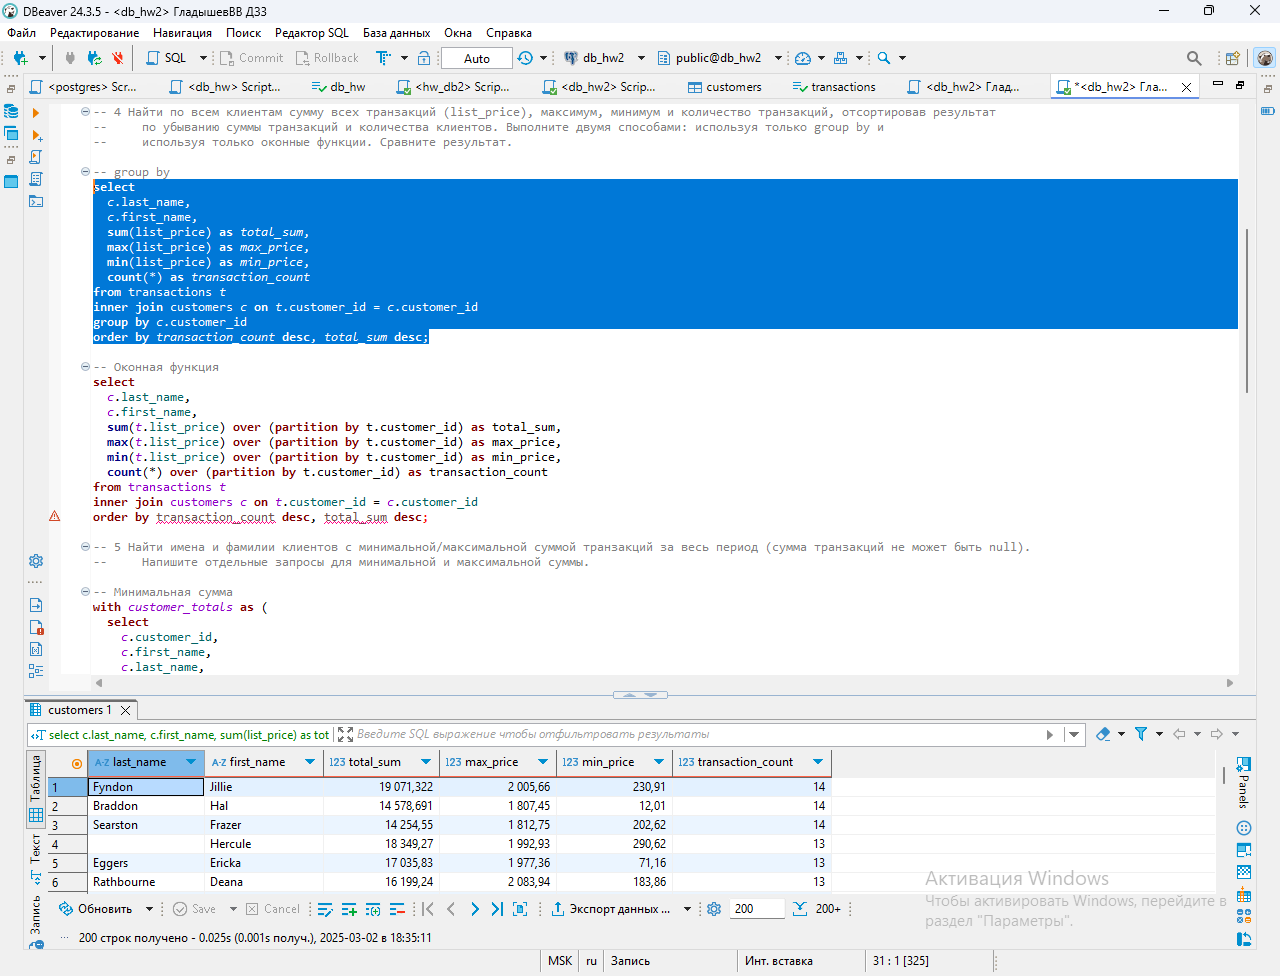

### Оконная функция

```sql
select
  c.last_name,
  c.first_name,
  sum(t.list_price) over (partition by t.customer_id) as total_sum,
  max(t.list_price) over (partition by t.customer_id) as max_price,
  min(t.list_price) over (partition by t.customer_id) as min_price,
  count(*) over (partition by t.customer_id) as transaction_count
from transactions t
inner join customers c on t.customer_id = c.customer_id
order by transaction_count desc, total_sum desc;
```

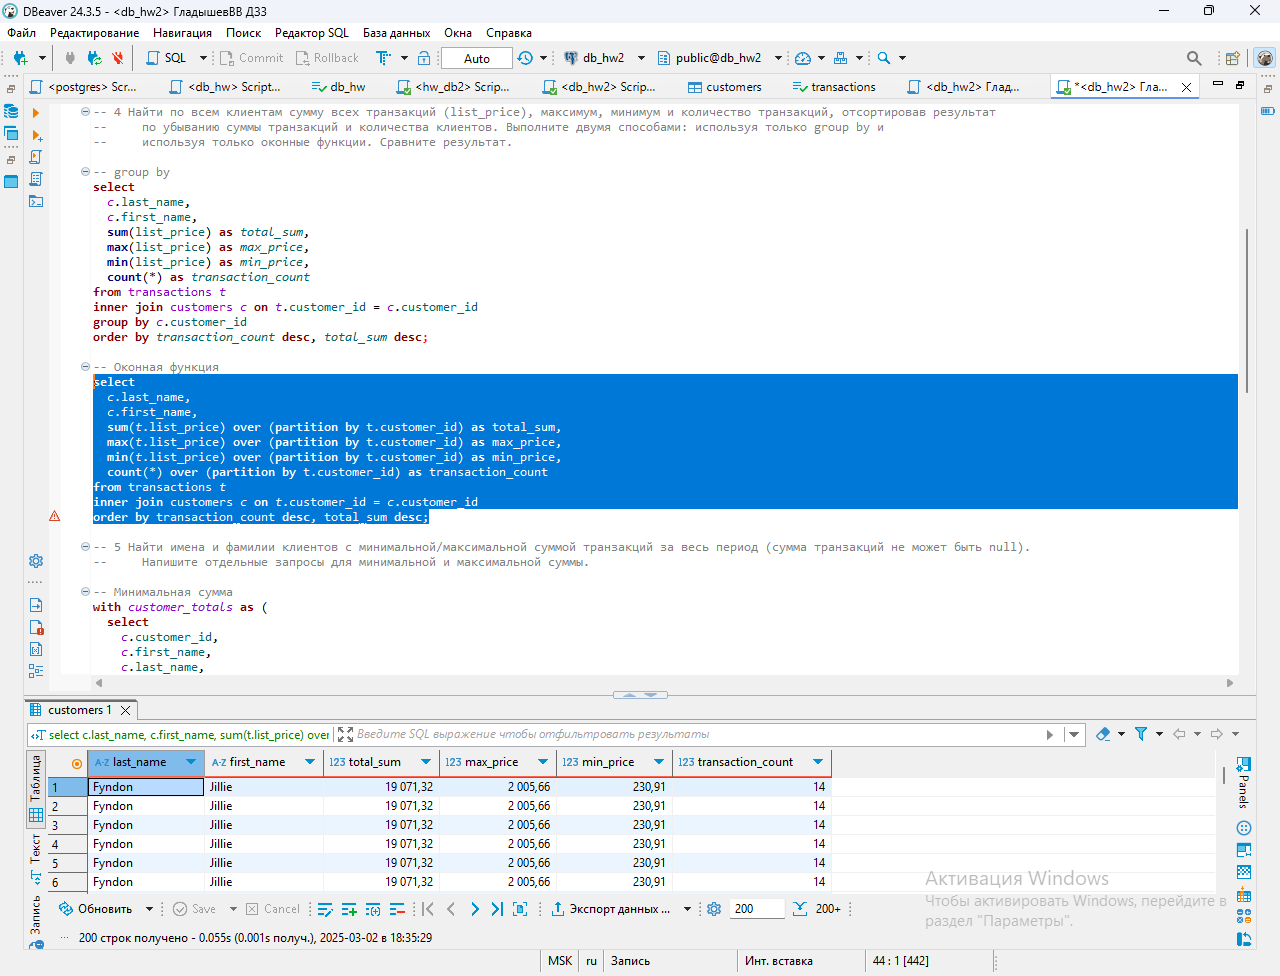

## Задание 5

Найти имена и фамилии клиентов с минимальной/максимальной суммой транзакций за весь период (сумма транзакций не может быть null). Напишите отдельные запросы для минимальной и максимальной суммы.

### Минимальная сумма

```sql
with customer_totals as (
  select
    c.customer_id,
    c.first_name,
    c.last_name,
    sum(t.list_price) as total
  from transactions t
  inner join customers c on t.customer_id = c.customer_id
  group by c.customer_id
)
select first_name, last_name, total
from customer_totals
where total = (select min(total) from customer_totals);
```

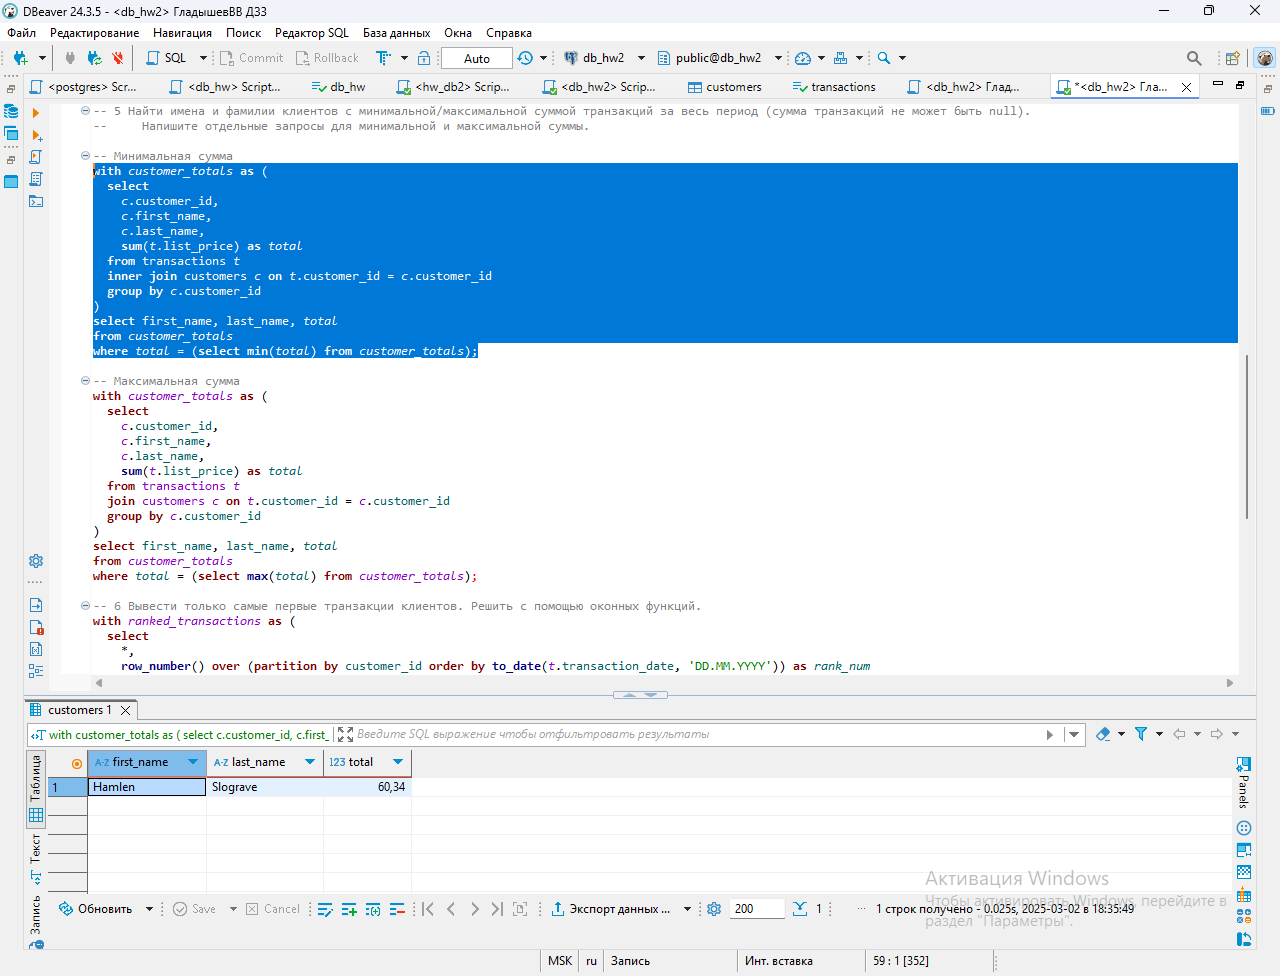

### Максимальная сумма

```sql
with customer_totals as (
  select
    c.customer_id,
    c.first_name,
    c.last_name,
    sum(t.list_price) as total
  from transactions t
  join customers c on t.customer_id = c.customer_id
  group by c.customer_id
)
select first_name, last_name, total
from customer_totals
where total = (select max(total) from customer_totals);
```

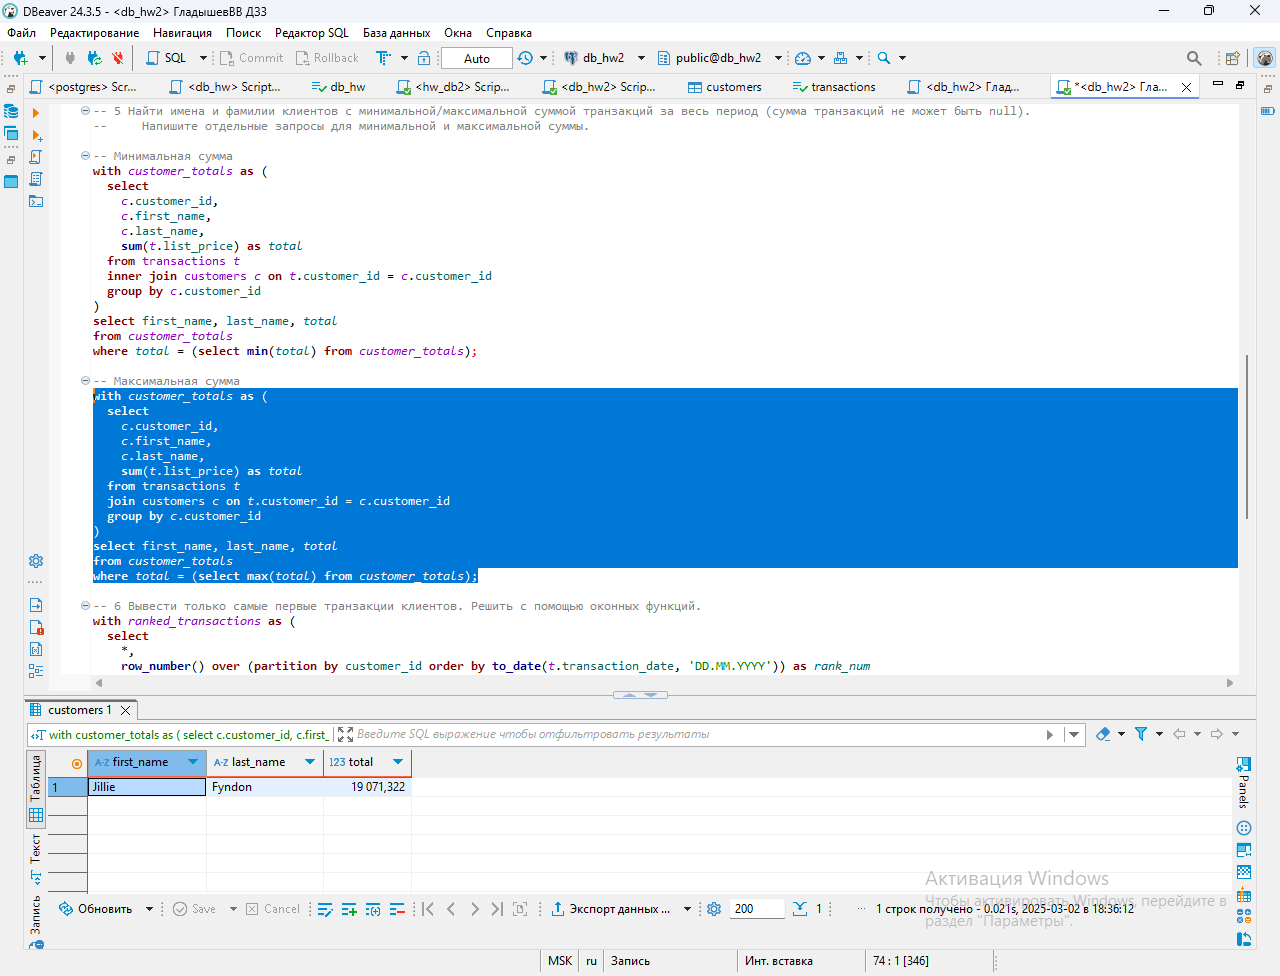

## Задание 6

Вывести только самые первые транзакции клиентов. Решить с помощью оконных функций.

```sql
with ranked_transactions as (
  select
    *,
    row_number() over (partition by customer_id order by to_date(t.transaction_date, 'DD.MM.YYYY')) as rank_num
  from transactions t
)
select transaction_id, transaction_date, brand, list_price, standard_cost
from ranked_transactions
where rank_num = 1;
```

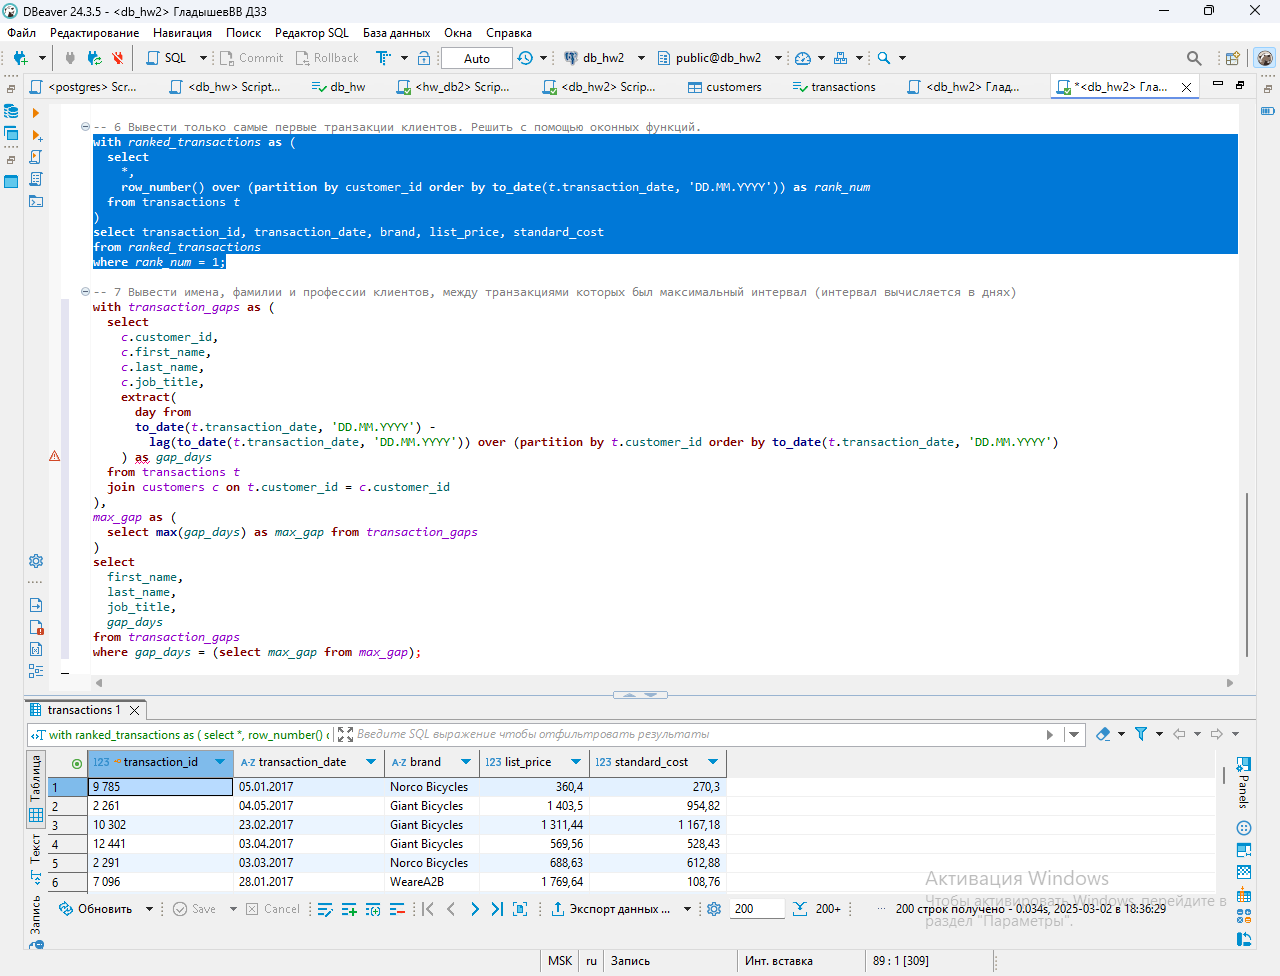

## Задание 7

Вывести имена, фамилии и профессии клиентов, между транзакциями которых был максимальный интервал (интервал вычисляется в днях)

Не доделал :(

```sql
with transaction_gaps as (
  select
    c.customer_id,
    c.first_name,
    c.last_name,
    c.job_title,
    extract(
      day from
      to_date(t.transaction_date, 'DD.MM.YYYY') -
      	lag(to_date(t.transaction_date, 'DD.MM.YYYY')) over (partition by t.customer_id order by to_date(t.transaction_date, 'DD.MM.YYYY')
    ) as gap_days
  from transactions t
  join customers c on t.customer_id = c.customer_id
),
max_gap as (
  select max(gap_days) as max_gap from transaction_gaps
)
select
  first_name,
  last_name,
  job_title,
  gap_days
from transaction_gaps
where gap_days = (select max_gap from max_gap);
```